# Monte Carlo Tree Search For Two Particle System
Simple test of the monte carlo tree search for a two particle system that must avoid each other.

**System**:

2D particles system with particles P1 and P2 each with $(x,y)$ coordinates and velocity: $(v_{x}, v_{y})$
Both particles must maintain a distance of X units.
Set of actions = [Turn left, Turn right, No Turn]

If action violates the distance restriction then it gets a reward of 0
If action ensures distance is greater than or equal to X then it gets positive reward.

End States:

1. Particle goes out of the coordinates system: Reward = 0
2. Particle violates distance: Rewards = 0
3. Particle satisfies distance requirement: Reward = 1.


In [16]:
from random import seed
from random import random
import numpy as np
import copy
import math

NUM_ACTIONS = 3
seed(1)

class particle_state:
    def __init__(self):
        self.x = random()
        self.y = random()
        self.v_x = random() * 10
        self.v_y = random() * 10
    
    def __str__(self):
        return f'''
            position: ({self.x},{self.y})\n
            velocity: ({self.v_x},{self.v_y})\n
        '''
    
    def getState(self):
        return (self.x, self.y, self.v_x, self.v_y)
    
    def move(self):
        dt = 0.002
        self.x = self.x + self.v_x*dt
        self.y = self.y + self.v_y*dt
        
        if abs(self.x - 1) < 0.01 or self.x < 0.01 :
            self.v_x = - self.v_x
        if abs(self.y - 1) < 0.01 or self.y < 0.01:
            self.v_y = - self.v_y
    
    def moveToA(self, pA): # For particle B.
        p = [pA.getState()[0] + (0.10)*pA.getState()[2], pA.getState()[1] + (0.10)*pA.getState()[3] ]
        self.v_x = (p[0] - self.x)/0.10
        self.v_y = (p[1] - self.y)/0.10
        
    def moveByAction(self, action: int):
        # 0: No Move, 1: Left Turn, 2: Right Turn. All turns are 90 deg.    
        if action is 1: # Left Turn
            self.v_x  = -1*self.v_x
        elif action is 2:
            self.v_y  = -1*self.v_y
        
        self.move()
    
            
def distance(A: particle_state, B: particle_state):
    return math.sqrt(pow((A.x - B.x),2) + pow((A.y - B.y),2))


# Monte Carlo Tree Seach State Node

In [17]:
class MCST_State:
    
    def __init__(self, A_state: particle_state, B_state: particle_state):
        # State properties
        self.A = A_state
        self.B = B_state
        self.score = 0
        self.simulations = 0
        
        # Child states based on the available actions.
        self.left = None
        self.right = None
        self.stay = None

        self.visited_child_count = 0
    def __str__(self):
        return f'''
            A: {str(self.A)}
            B: {str(self.B)}
            score: {self.score}
            simulations: {self.simulations}
        '''
    
    def isFinal(self):
        d =  distance(self.A,self.B)
        if d > 0.20:
            return d - 0.20
        # Out of bound check
        
        # Not a final state.
        return -1
        

# Monte Carlo Search Tree Implementation
## Select, Expand, Simulate, Backpropagate

In [18]:
class MCST:
    def __init__(self, A_state, B_state):
        # MCST initial state
        self.root = MCST_State(A_state, B_state)
        self.statesPath = []
    
    def getBestAction(self):
        simulations_count = [self.root.stay.simulations, self.root.left.simulations, self.root.right.simulations]
        action_index = simulations_count.index(max(simulations_count))
        return action_index
        
    def selection(self):
        mcst_node = self.root
        # While a given state node has been expanded, select a child using UCB1.
        
        while mcst_node.visited_child_count == 3:
            
            c = math.sqrt(2)
            
            UCB1_left = (mcst_node.left.score)/(mcst_node.left.simulations) + c*(math.sqrt(math.log(mcst_node.simulations)/mcst_node.left.simulations))
            UCB1_right =(mcst_node.right.score)/(mcst_node.right.simulations) + c*(math.sqrt(math.log(mcst_node.simulations)/mcst_node.right.simulations))
            UCB1_stay = (mcst_node.stay.score)/(mcst_node.stay.simulations) + c*(math.sqrt(math.log(mcst_node.simulations)/mcst_node.stay.simulations))
            values = [UCB1_stay,UCB1_left,UCB1_right,]
            
            nextChildIndex = values.index(max(UCB1_stay,UCB1_left,UCB1_right))
            if(nextChildIndex == 0):
                mcst_node = mcst_node.stay
                
            elif(nextChildIndex == 1):
                mcst_node = mcst_node.left
            else:
                mcst_node = mcst_node.right
            
            self.statesPath.append(mcst_node)
        
        self.statesPath.append(mcst_node)
        return mcst_node
    
    def expansion(self, mcst_node):
        # TODO: Expansion should take into account B moving.
        # Expansion should pick a child node not expanded previously
        while True:
            rand_num = random()
            if rand_num < 0.33 and mcst_node.stay is None:
                # Stay
                mcst_node.stay = MCST_State(mcst_node.A, mcst_node.B)
                self.statesPath.append(mcst_node.stay)
                break
            elif rand_num < 0.66 and mcst_node.left is None:
                # Left
                stateAfterAction = copy.copy(mcst_node.A)
                stateAfterAction.moveByAction(1)
                mcst_node.left = MCST_State(stateAfterAction,mcst_node.B)
                self.statesPath.append(mcst_node.left)
                break
            elif rand_num < 0.99 and mcst_node.right is None:
                # Right
                stateAfterAction = copy.copy(mcst_node.A)
                stateAfterAction.moveByAction(2)
                mcst_node.right = MCST_State(stateAfterAction,mcst_node.B)
                self.statesPath.append(mcst_node.right)
                break
                
        mcst_node.visited_child_count += 1
        
    def simulate(self):
        score = 0
        while True:
            simState = self.statesPath[-1]
            rand_num = random()
            if rand_num < 0.33:
                pass
            elif rand_num < 0.66:
                # Left
                simState.A.moveByAction(1)
            else:
                # Right
                simState.A.moveByAction(2)
            
            if simState.isFinal() >= 0:
                # Compute Reward/Score and backpropagate.
                score = simState.isFinal()
                # print(f"Fixed Confict, Score: {score}")
                break
        self.backpropagate(score)

    def backpropagate(self, score):
        for state in self.statesPath:
            state.score += score
            state.simulations += 1
        # Empty statesPath for next selection round.
#         for state in mct.statesPath:
#             print(state)
#             print("------")
        self.statesPath.clear()
        

# Simulation Graphics

<IPython.core.display.Javascript object>


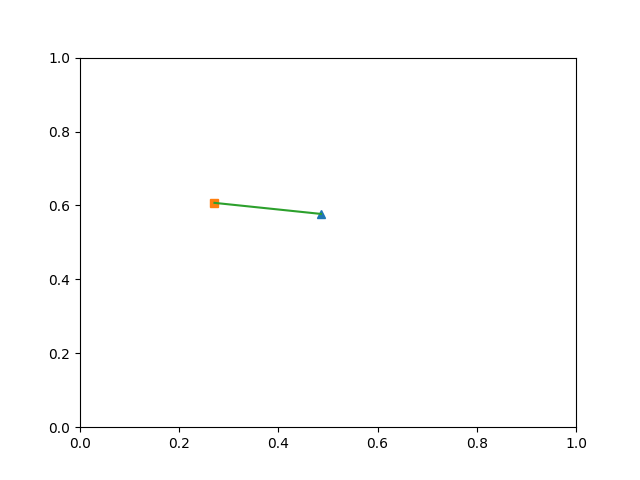

Not Well Clear
Best Move: 2

            position: (0.7148329545346283,0.9392585862034253)

            velocity: (-7.6377461897661405,-2.550690257394217)

        
Not Well Clear
Best Move: 0

            position: (0.699557462155096,0.47503295935767403)

            velocity: (7.6377461897661405,-2.550690257394217)

        
Not Well Clear
Best Move: 0

            position: (0.806485908811822,0.4495260567837319)

            velocity: (7.6377461897661405,-2.550690257394217)

        
Not Well Clear
Best Move: 1

            position: (0.8523123859504189,0.4444246762689435)

            velocity: (-7.6377461897661405,-2.550690257394217)

        
Not Well Clear
Best Move: 1

            position: (0.8370368935708866,0.4699315788428856)

            velocity: (-7.6377461897661405,2.550690257394217)

        
Not Well Clear
Best Move: 2

            position: (0.699557462155096,0.5056412424464046)

            velocity: (-7.6377461897661405,-2.550690257394217)

        
Not Well Clear


KeyboardInterrupt: 

In [19]:
pA = particle_state()
pB = particle_state()

%matplotlib notebook

import matplotlib.pyplot as plt
import time
import math

# draw the figure so the animations will work
fig = plt.gcf()
# fig.set_size_inches(5, 5)
fig.show()
fig.canvas.draw()


b_iteration = 0
while True:
    plt.clf()
    plt.plot(pA.getState()[0],pA.getState()[1], '^')
    plt.plot(pB.getState()[0],pB.getState()[1], 's')
    
    x1, y1 = [pA.getState()[0], pB.getState()[0]], [pA.getState()[1],pB.getState()[1]]
    plt.plot(x1,y1)
    
    # update canvas immediately
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    fig.canvas.draw()
    
    # Every 100 iteration particle B makes a random move.
    if b_iteration == 100:
        pB.moveToA(pA)
        b_iteration=0
        
    if distance(pA,pB) <= 0.20:
        print("Not Well Clear")
        # Make a move using the Monte Carlo Search Tree.
        mct = MCST(pA,pB)
        
        for i in range(1000):
            selected = mct.selection()
            mct.expansion(selected)
            mct.simulate()
            
        best_action = mct.getBestAction()    
        print(f"Best Move: {best_action}")
        pA.moveByAction(best_action)
        pB.move()
        print(pA)
        time.sleep(0.05)
        continue
        
    pA.move()
    pB.move()
    b_iteration+=1 
    time.sleep(0.05)
    